#Implementing Neural Networks from scratch

In [ ]:
#import libraries
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

In [ ]:
#import dataset
#store ytrain and ytest to find accuracy
(x_train, ytrain), (x_test, ytest) = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train/255
#one hot encode ytrain
y_train = np_utils.to_categorical(ytrain)
x_test = x_test.astype('float32')
x_test = x_test/255
#one hot encode ytest
y_test = np_utils.to_categorical(ytest)

In [ ]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

#Model

In [ ]:
#Flattens input
class FlattenLayer:
    def __init__(self, inputShape):
        self.inputShape = inputShape
    def forward(self, input):
        return np.reshape(input, (1, -1))
    def backward(self, outputError, learning_rate):
        return np.reshape(outputError, self.inputShape)

In [ ]:
#Neural Network Layers
class Layer:
    def __init__(self, inputSize, outputSize):
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.weights = np.random.randn(inputSize, outputSize)/np.sqrt(inputSize + outputSize)
        self.bias = np.random.randn(1, outputSize)/np.sqrt(inputSize + outputSize)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, outputError, learning_rate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        self.weights -= learning_rate*weightsError
        self.bias -= learning_rate*outputError
        return inputError

In [ ]:
#Activation
class ActivationLayer:
    def __init__(self, activation, activationD):
        self.activation = activation
        self.activationD = activationD

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, outputError, learning_rate):
        return outputError*self.activationD(self.input)

In [ ]:
#Softmax
class Softmax:
    def __init__(self, inputSize):
        self.inputSize = inputSize

    def forward(self, input):
        self.input = input
        ext = np.exp(input)
        self.output = ext/np.sum(ext)
        return self.output

    def backward(self, outputError, learning_rate):
        inputError = np.zeros(outputError.shape)
        out = np.tile(self.output.T, self.inputSize)
        return self.output*np.dot(outputError, np.identity(self.inputSize) - out)

In [ ]:
#Tanh
def tanh(x):
    return np.tanh(x)

def tanhDerivative(x):
    return 1 - np.tanh(x)**2

In [ ]:
#ReLu
def relu(x):
    if x>0:
      return x
    else:
      return 0

def reluDerivative(x):
    return np.array(x >= 0).astype('int')

In [ ]:
#MSE loss
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mseDerivate(y_true, y_pred):
    return 2 * (y_pred - y_true)/y_pred.size

In [ ]:
#Catergorical cross entropy
def crossEntropy(y_true,y_pred):
  return -np.sum(y_true * np.log(y_pred + 10**-100))

def crossEntropyDerivative(y_true,y_pred):
  return -y_true/(y_pred + 10**-100)

In [ ]:
#Predicting output
def predict(net, input):
    output = input
    for layer in net:
        output = layer.forward(output)
    return output

In [ ]:
#Model
net = [
    FlattenLayer(inputShape=(28, 28)),
    Layer(28 * 28, 128),
    ActivationLayer(relu, reluDerivative),
    Layer(128, 10),
    Softmax(10)
]

In [ ]:
#training the model with train data and testing on test data
learning_rate = 0.001
error_train = []
error_test = []
acc_train = []
acc_test = []
#8 epochs
for i in range(8):
    error = 0
    for x, y_true in zip(x_train, y_train):
        output = x
        #forward propogation
        for layer in net:
            output = layer.forward(output)
        error += crossEntropy(y_true, output)
        #backward propogation
        output_error = crossEntropyDerivative(y_true, output)
        for layer in reversed(net):
            output_error = layer.backward(output_error, learning_rate)

    #Collecting test and train accuracies and errors.
    test = sum([crossEntropy(y, predict(net, x)) for x, y in zip(x_test, y_test)])/len(x_test)
    error_test.append(test)
    error /= len(x_train)
    error_train.append(error)
    pred_train = [np.argmax(predict(net, x)[0]) for x, y in zip(x_train, y_train)]
    pred_test = [np.argmax(predict(net, x)[0]) for x, y in zip(x_test, y_test)]
    acc_train.append(accuracy_score(ytrain,pred_train))
    acc_test.append(accuracy_score(ytest,pred_test))
    print("%d, error=%f, test_error=%f" % (i+1, error,test))

1, error=0.463129, test_error=0.283391
2, error=0.251229, test_error=0.221182
3, error=0.200123, test_error=0.183552
4, error=0.167141, test_error=0.158510
5, error=0.143622, test_error=0.141136
6, error=0.126119, test_error=0.128829
7, error=0.112453, test_error=0.119236
8, error=0.101459, test_error=0.111692


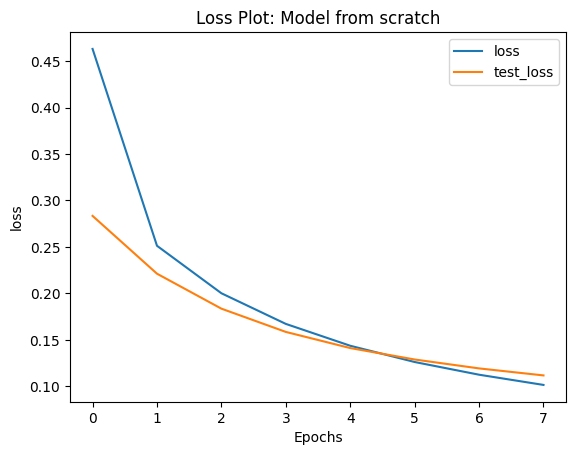

In [ ]:
#Loss plot
ep = np.arange(8)
plt.plot(ep,error_train,label='loss')
plt.plot(ep,error_test,label='test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.title("Loss Plot: Model from scratch")
plt.show()

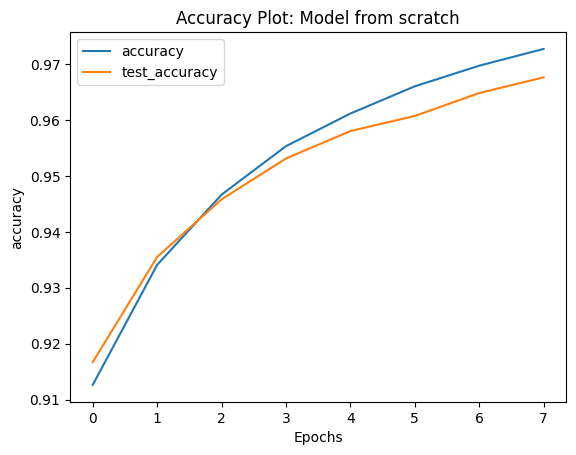

In [ ]:
#Accuracy plot
ep = np.arange(8)
plt.plot(ep,acc_train,label='accuracy')
plt.plot(ep,acc_test,label='test_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.title("Accuracy Plot: Model from scratch")
plt.show()

#TensorFlow model

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
opt = keras.optimizers.SGD(learning_rate= 0.01)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fit = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs= 8)

Epoch 1/8
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6645 - accuracy: 0.8306 - val_loss: 0.3627 - val_accuracy: 0.9003
Epoch 2/8
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3405 - accuracy: 0.9048 - val_loss: 0.2982 - val_accuracy: 0.9176
Epoch 3/8
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2925 - accuracy: 0.9174 - val_loss: 0.2658 - val_accuracy: 0.9268
Epoch 4/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2620 - accuracy: 0.9257 - val_loss: 0.2420 - val_accuracy: 0.9321
Epoch 5/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2385 - accuracy: 0.9326 - val_loss: 0.2227 - val_accuracy: 0.9369
Epoch 6/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2190 - accuracy: 0.9385 - val_loss: 0.2064 - val_accuracy: 0.9402
Epoch 7/8
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2030 - accuracy: 0.9427 - val_loss: 0.1957 - val_accuracy: 0.9

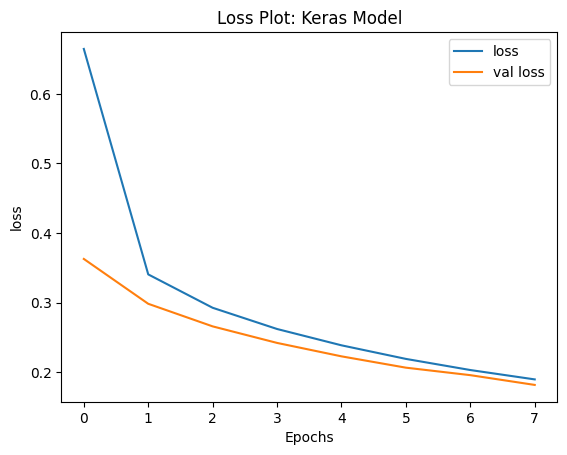

In [ ]:
#Loss plot
iterations=np.arange(8)
plt.plot(iterations,fit.history["loss"],label='loss')
plt.plot(iterations,fit.history["val_loss"],label='val loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.title("Loss Plot: Keras Model")
plt.show()

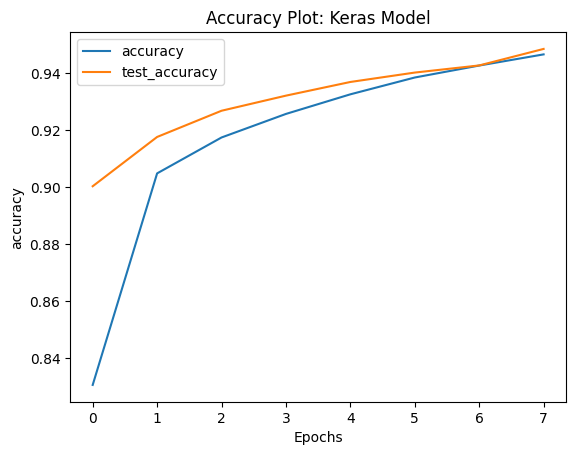

In [ ]:
#Accuracy Model
iterations=np.arange(8)
plt.plot(iterations,fit.history["accuracy"],label='accuracy')
plt.plot(iterations,fit.history["val_accuracy"],label='test_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.title("Accuracy Plot: Keras Model")
plt.show()